In [71]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt

repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))
from will_replication.my_utils.utils import plot_pareto_frontier, get_json_responses, SIMPLE_MODEL_POOL_CONFIG, TOKENS_PER_MILLION

In [72]:
BASELINE_DATASETS_LIST = [
                        "opencompass/AIME2025", #test
                        "gneubig/aime-1983-2024", #train
                        "openai/gsm8k", #test
                        "DigitalLearningGmbH/MATH-lighteval" #test
                        ]

In [73]:
MODEL_POOL = [
    "Qwen-Qwen2.5-Math-1.5B-Instruct",
    "Qwen-Qwen2.5-Math-7B-Instruct",
    "Qwen-Qwen2.5-Math-72B-Instruct",
              ]

In [74]:
def update_pricing_in_dataframe(df, model_name_col="model_name", input_token_col="total_input_tokens", output_token_col="total_output_tokens"):
    """
    Update pricing columns in a dataframe based on model_name and SIMPLE_MODEL_POOL_CONFIG.
    """
    for model_name in df[model_name_col].unique():
        if model_name not in SIMPLE_MODEL_POOL_CONFIG:
            print(f"Warning: {model_name} not found in SIMPLE_MODEL_POOL_CONFIG")
            continue
        
        input_cost = SIMPLE_MODEL_POOL_CONFIG[model_name]['model_costs']["input_per_mill"] / TOKENS_PER_MILLION
        output_cost = SIMPLE_MODEL_POOL_CONFIG[model_name]['model_costs']["output_per_mill"] / TOKENS_PER_MILLION
        
        mask = df[model_name_col] == model_name
        df.loc[mask, "input_cost_usd_once"] = df.loc[mask, input_token_col] * input_cost
        df.loc[mask, "total_output_cost_usd"] = df.loc[mask, output_token_col] * output_cost
        df.loc[mask, "total_cost_usd"] = df.loc[mask, "input_cost_usd_once"] + df.loc[mask, "total_output_cost_usd"]

In [75]:
# GENERATION_CONFIG
BASELINE_K=1
BASELINE_TEMP=0.0

PROBE_MODEL_DATA_SOURCE = "DigitalLearningGmbH_MATH-lighteval"
PROBE_PROBE_K=1
PROBE_PROBE_TEMP=0.0

ROUTING_MAX_K=1
ROUTING_TEMP=0.0
# ROUTER_OPTIONS="easy-3_hard-1_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-2_hard-4_medium-3_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5"
# ROUTER_OPTIONS="easy-8_hard-8_medium-8"
ROUTER_OPTIONS="greedy"

ROUTER_THRESHOLDS="E0.9_M0.4"
# ROUTER_THRESHOLDS="E0.8_M0.4"
# ROUTER_THRESHOLDS="E0.9_M0.3"

ROUTING_MODEL = "Qwen_Qwen2.5-Math-1.5B-Instruct"

In [76]:
def load_cascade_router_results(router_result_df_path):
    # cascade_df = pd.read_parquet("../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/DigitalLearningGmbH_MATH-lighteval_routed/answered_bayes_cascade.parquet")
    cascade_df = pd.read_parquet(router_result_df_path)
    update_pricing_in_dataframe(cascade_df, model_name_col="route_to", input_token_col="input_num_tokens", output_token_col="response_num_tokens")

    cascade_sr_score = cascade_df["passk_score"].mean()
    cascade_majority_vote_score = cascade_df["majority_vote_is_correct"].mean()
    cascade_total_cost = cascade_df["total_cost_usd"].sum()

    print('===============================\n')
    print(f"Accuracy: {cascade_majority_vote_score}")
    print(f"Passk: {cascade_sr_score}")
    print(f"Cost: {cascade_total_cost}")
    print("Router question breakdown:")
    print(cascade_df['route_to'].value_counts())
    print('===============================\n')

    return cascade_majority_vote_score, cascade_sr_score, cascade_total_cost

In [77]:
router_res_df = load_cascade_router_results("../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/openai_gsm8k_routed/answered_bayes_cascade.parquet")


Accuracy: 0.9021986353297953
Passk: 0.9021986353297953
Cost: 0.1454316
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-1.5B-Instruct    953
Qwen/Qwen2.5-Math-72B-Instruct     199
Qwen/Qwen2.5-Math-7B-Instruct      167
Name: count, dtype: int64




Accuracy: 0.2
Passk: 0.2
Cost: 0.0181024
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    14
Qwen/Qwen2.5-Math-7B-Instruct      1
Name: count, dtype: int64


Accuracy: 0.13333333333333333
Passk: 0.13333333333333333
Cost: 0.018164700000000002
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    15
Name: count, dtype: int64


Accuracy: 0.13333333333333333
Passk: 0.13333333333333333
Cost: 0.0183249
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    15
Name: count, dtype: int64


Accuracy: 0.3140407288317256
Passk: 0.3140407288317256
Cost: 0.6369567
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-7B-Instruct      473
Qwen/Qwen2.5-Math-72B-Instruct     429
Qwen/Qwen2.5-Math-1.5B-Instruct     31
Name: count, dtype: int64


Accuracy: 0.3579849946409432
Passk: 0.3579849946409432
Cost: 0.9922704000000002
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct     898
Qwen/Qwen2.5-Math-1.5B-Instruct     31
Qwen/Qwen2.5-Ma

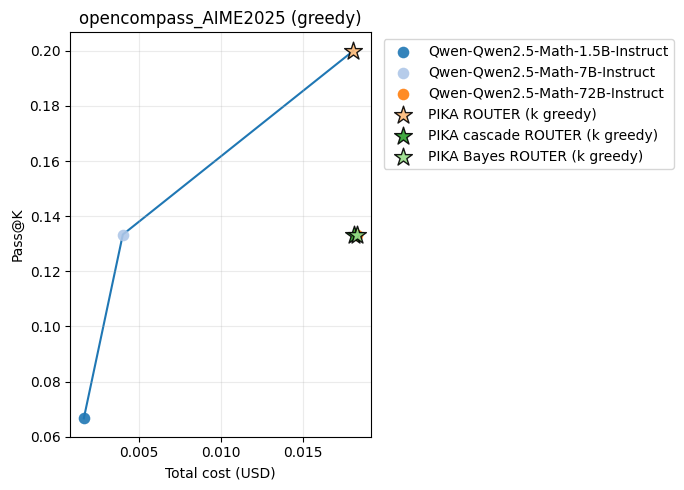

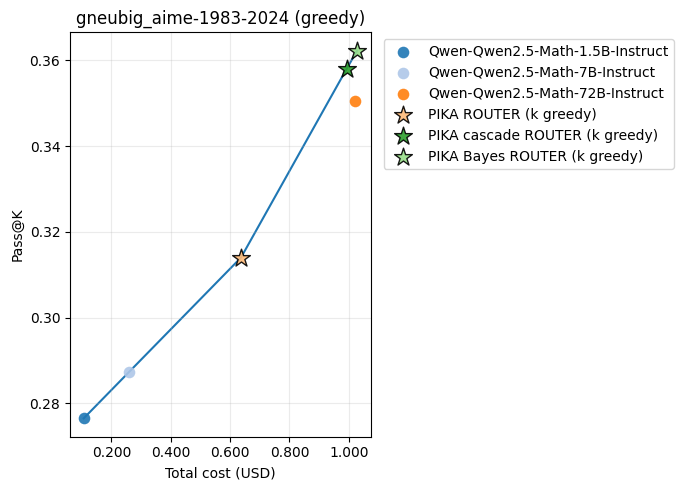

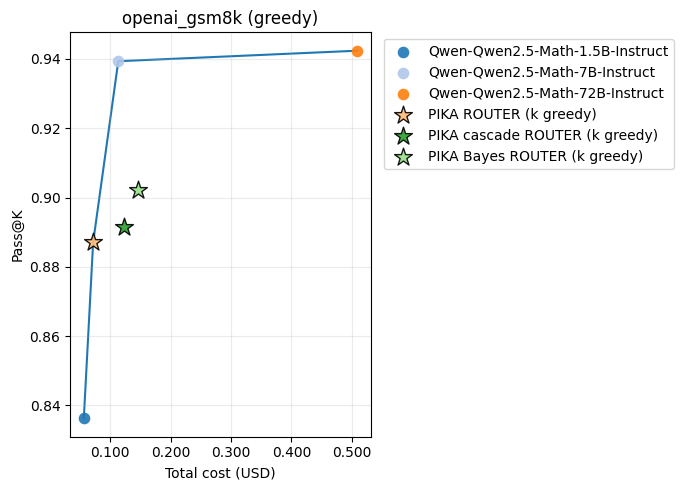

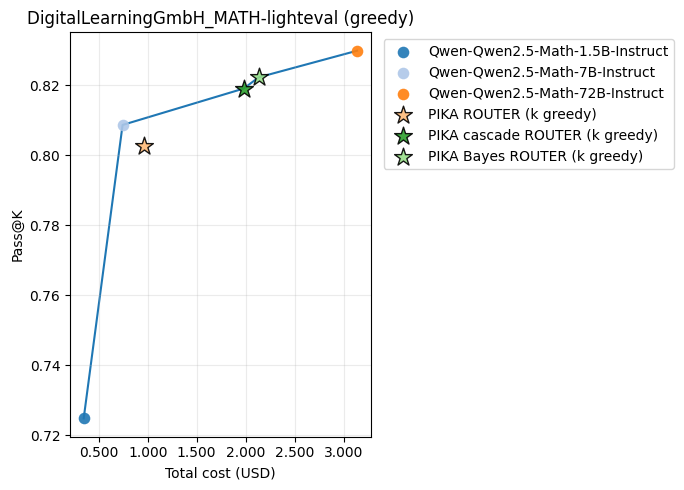

In [78]:
PLOTTING_DICT = dict()
for BASELINE_DATASET_NAME in BASELINE_DATASETS_LIST:
    BASELINE_BENCHMARK_ALIAS = "_".join(BASELINE_DATASET_NAME.split("/"))

    BENCHMARK_DATA_POINTS = []
    for MODEL_NAME in MODEL_POOL:
        if "aime-1983" in BASELINE_BENCHMARK_ALIAS: #only has train set
            BASELINE_PATH = f"../../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/train-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"
        else:
            BASELINE_PATH = f"../../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/test-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"

        BASELINE_BENCHMARK_DF = pd.read_parquet(BASELINE_PATH)
        update_pricing_in_dataframe(BASELINE_BENCHMARK_DF)
        

        benchmark_sr_score = BASELINE_BENCHMARK_DF["success_rate"].mean()

        if "majority_vote_is_correct" in BASELINE_BENCHMARK_DF.columns:
            benchmark_majority_vote_score = BASELINE_BENCHMARK_DF["majority_vote_is_correct"].mean()
        else:
            benchmark_majority_vote_score = np.nan

        benchmark_cost = BASELINE_BENCHMARK_DF["total_cost_usd"].sum()
        BENCHMARK_DATA_POINTS.append({"name": MODEL_NAME, "passk_score": benchmark_sr_score, "majority_vote_score":benchmark_majority_vote_score, "cost": benchmark_cost})

        
        
    PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] = BENCHMARK_DATA_POINTS

    PIKA_V2_DIR = f"../pika_router_runs/{BASELINE_BENCHMARK_ALIAS}_routed_by_{PROBE_MODEL_DATA_SOURCE}_{ROUTING_MODEL}_probeK{PROBE_PROBE_K}_probeT{PROBE_PROBE_TEMP}_routeK{ROUTING_MAX_K}_routeT{ROUTING_TEMP}_sc_{ROUTER_OPTIONS}_thresh{ROUTER_THRESHOLDS}.parquet"
    try:
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(PIKA_V2_DIR)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")
    
    # load other routers:
    try:
        cascade_path = f"../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/{BASELINE_BENCHMARK_ALIAS}_routed/answered_cascade.parquet"
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(cascade_path)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA cascade ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")

    try:
        bayes_cascade_path = f"../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/{BASELINE_BENCHMARK_ALIAS}_routed/answered_bayes_cascade.parquet"
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(bayes_cascade_path)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA Bayes ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")

for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += f" ({ROUTER_OPTIONS})"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K})"
    plot_pareto_frontier(data_points, benchmark, score_col="passk_score", x_label="Total cost (USD)", y_label=f"Pass@K")


In [79]:
# === LOAD ALL ROUTING STRATEGY RESULTS ===
# Load results from all executed routing strategies

import glob
from pathlib import Path

# Configuration
PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
RESULTS_BASE_DIR = "../../pika_cascade_trial"
TARGET_CONF = 0.90

print("=" * 80)
print("LOADING ROUTING STRATEGY RESULTS")
print("=" * 80)

# Find all strategy result files
strategy_results = {}
result_pattern = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/*/answered_*_conf{TARGET_CONF}.parquet"
result_files = sorted(glob.glob(result_pattern))

print(f"\nSearching for results matching: {result_pattern}")
print(f"Found {len(result_files)} result files\n")

for result_path in result_files:
    try:
        # Parse filename to extract dataset and strategy
        path_obj = Path(result_path)
        filename = path_obj.stem  # answered_cascade_conf0.9
        
        # Extract strategy name
        parts = filename.split("_")  # ['answered', 'cascade', 'conf0', '9']
        if parts[0] == "answered" and len(parts) >= 2:
            strategy_name = "_".join(parts[1:-1])  # rejoin parts between 'answered' and 'conf'
            dataset_dir = path_obj.parent.name  # e.g., "openai_gsm8k_routed"
            dataset_name = dataset_dir.replace("_routed", "")
            
            # Load results
            results_df = pd.read_parquet(result_path)
            results_df['dataset'] = dataset_name
            
            # Extract metrics
            accuracy = results_df["majority_vote_is_correct"].mean()
            passk = results_df["passk_score"].mean()
            cost = results_df["total_cost_usd"].sum()
            
            
            key = f"{dataset_name}_{strategy_name}"
            strategy_results[key] = {
                'dataset': dataset_name,
                'strategy': strategy_name,
                'accuracy': accuracy,
                'passk': passk,
                'cost': cost,
                'path': result_path,
                'df': results_df,
            }
            
            print(f"✓ Loaded: {strategy_name:30s} | {dataset_name:30s}")
            print(f"  Accuracy: {accuracy:.4f} | Pass@K: {passk:.4f} | Cost: ${cost:.4f}")
            
    except Exception as e:
        print(f"✗ Error loading {result_path}: {e}")

print(f"\n✓ Total strategies loaded: {len(strategy_results)}")

# Create consolidated results dataframe
if strategy_results:
    strategy_results_df = pd.DataFrame([
        {
            'dataset': v['dataset'],
            'strategy': v['strategy'],
            'accuracy': v['accuracy'],
            'passk': v['passk'],
            'cost': v['cost'],
        }
        for v in strategy_results.values()
    ])
    
    print("\n" + "=" * 80)
    print("CONSOLIDATED RESULTS")
    print("=" * 80)
    print(strategy_results_df.sort_values('accuracy', ascending=False).to_string(index=False))
else:
    print("⚠ No strategy results found. Run execute_strategies.py first.")
    strategy_results_df = pd.DataFrame()


LOADING ROUTING STRATEGY RESULTS

Searching for results matching: ../../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/*/answered_*_conf0.9.parquet
Found 9 result files

✓ Loaded: 72b_robust                     | openai_gsm8k                  
  Accuracy: 0.9030 | Pass@K: 0.9030 | Cost: $0.1453
✓ Loaded: adjusted_thresholds            | openai_gsm8k                  
  Accuracy: 0.8931 | Pass@K: 0.8931 | Cost: $0.0992
✓ Loaded: always_1.5B                    | openai_gsm8k                  
  Accuracy: 0.8355 | Pass@K: 0.8355 | Cost: $0.0562
✓ Loaded: bayesian_robust                | openai_gsm8k                  
  Accuracy: 0.9030 | Pass@K: 0.9030 | Cost: $0.1453
✓ Loaded: cascade                        | openai_gsm8k                  
  Accuracy: 0.8946 | Pass@K: 0.8946 | Cost: $0.1203
✓ Loaded: cost_utility                   | openai_gsm8k                  
  Accuracy: 0.8946 | Pass@K: 0.8946 | Cost: $0.1204
✓ Loaded: disagreement_0.10              | openai_gsm8k      

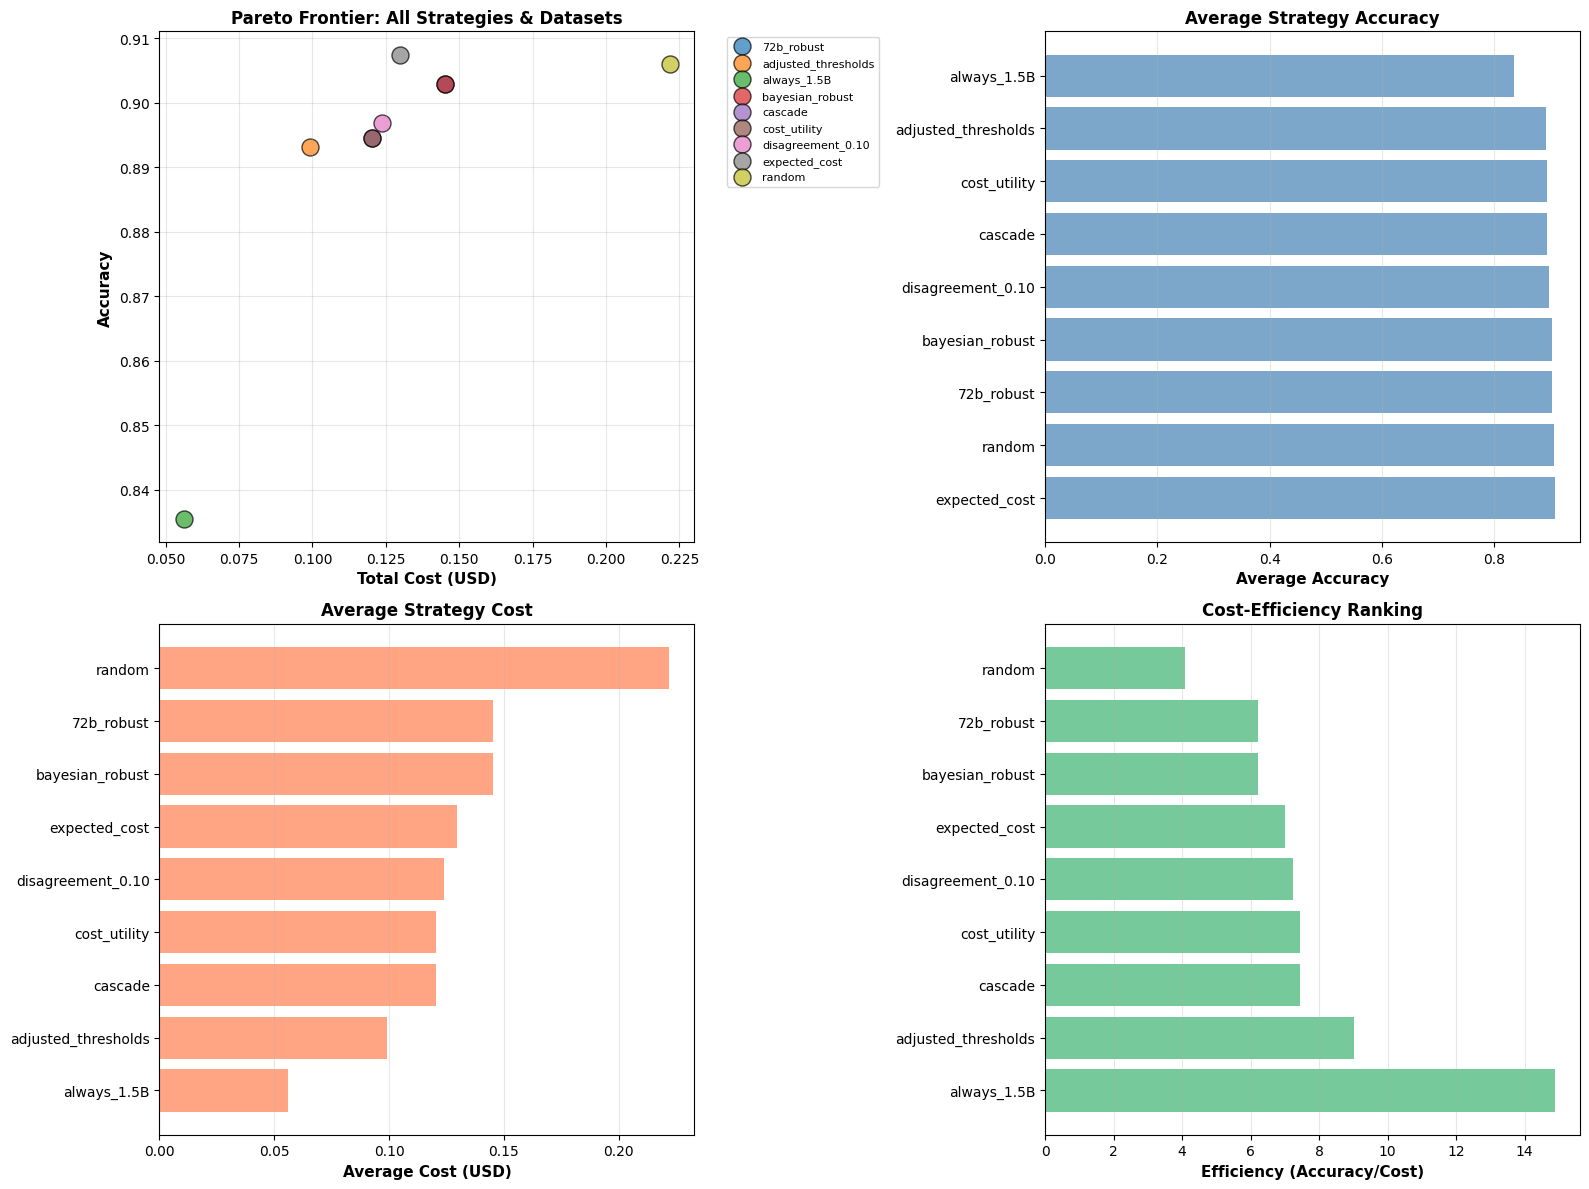


STRATEGY RANKINGS

Best Accuracy:
  expected_cost                  (openai_gsm8k                  ): 0.9075

Lowest Cost:
  always_1.5B                    (openai_gsm8k                  ): $0.0562

Best Efficiency (Accuracy/Cost):
  always_1.5B                    (openai_gsm8k                  ): 14.875376


In [80]:
# === STRATEGY PARETO FRONTIER ANALYSIS ===
# Visualize cost-accuracy tradeoffs for all strategies

if not strategy_results_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall Pareto Frontier (all datasets)
    ax1 = axes[0, 0]
    for strategy in strategy_results_df['strategy'].unique():
        strategy_data = strategy_results_df[strategy_results_df['strategy'] == strategy]
        ax1.scatter(strategy_data['cost'], strategy_data['accuracy'], 
                   label=strategy, s=150, alpha=0.7, edgecolor='black', linewidth=1)
    
    ax1.set_xlabel('Total Cost (USD)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax1.set_title('Pareto Frontier: All Strategies & Datasets', fontsize=12, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Strategy Performance (avg across datasets)
    ax2 = axes[0, 1]
    strategy_avg = strategy_results_df.groupby('strategy')[['accuracy', 'cost']].mean()
    strategy_avg = strategy_avg.sort_values('accuracy', ascending=False)
    
    ax2.barh(range(len(strategy_avg)), strategy_avg['accuracy'].values, color='steelblue', alpha=0.7)
    ax2.set_yticks(range(len(strategy_avg)))
    ax2.set_yticklabels(strategy_avg.index)
    ax2.set_xlabel('Average Accuracy', fontsize=11, fontweight='bold')
    ax2.set_title('Average Strategy Accuracy', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Cost Comparison
    ax3 = axes[1, 0]
    strategy_cost = strategy_results_df.groupby('strategy')['cost'].mean().sort_values()
    
    ax3.barh(range(len(strategy_cost)), strategy_cost.values, color='coral', alpha=0.7)
    ax3.set_yticks(range(len(strategy_cost)))
    ax3.set_yticklabels(strategy_cost.index)
    ax3.set_xlabel('Average Cost (USD)', fontsize=11, fontweight='bold')
    ax3.set_title('Average Strategy Cost', fontsize=12, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Cost-Efficiency Score
    ax4 = axes[1, 1]
    strategy_results_df['efficiency'] = strategy_results_df['accuracy'] / (strategy_results_df['cost'] + 1e-6)
    efficiency_avg = strategy_results_df.groupby('strategy')['efficiency'].mean().sort_values(ascending=False)
    
    ax4.barh(range(len(efficiency_avg)), efficiency_avg.values, color='mediumseagreen', alpha=0.7)
    ax4.set_yticks(range(len(efficiency_avg)))
    ax4.set_yticklabels(efficiency_avg.index)
    ax4.set_xlabel('Efficiency (Accuracy/Cost)', fontsize=11, fontweight='bold')
    ax4.set_title('Cost-Efficiency Ranking', fontsize=12, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("STRATEGY RANKINGS")
    print("=" * 80)
    
    print("\nBest Accuracy:")
    best_acc_idx = strategy_results_df['accuracy'].idxmax()
    best_acc = strategy_results_df.loc[best_acc_idx]
    print(f"  {best_acc['strategy']:30s} ({best_acc['dataset']:30s}): {best_acc['accuracy']:.4f}")
    
    print("\nLowest Cost:")
    lowest_cost_idx = strategy_results_df['cost'].idxmin()
    lowest_cost = strategy_results_df.loc[lowest_cost_idx]
    print(f"  {lowest_cost['strategy']:30s} ({lowest_cost['dataset']:30s}): ${lowest_cost['cost']:.4f}")
    
    print("\nBest Efficiency (Accuracy/Cost):")
    efficiency_max_idx = strategy_results_df['efficiency'].idxmax()
    best_eff = strategy_results_df.loc[efficiency_max_idx]
    print(f"  {best_eff['strategy']:30s} ({best_eff['dataset']:30s}): {best_eff['efficiency']:.6f}")


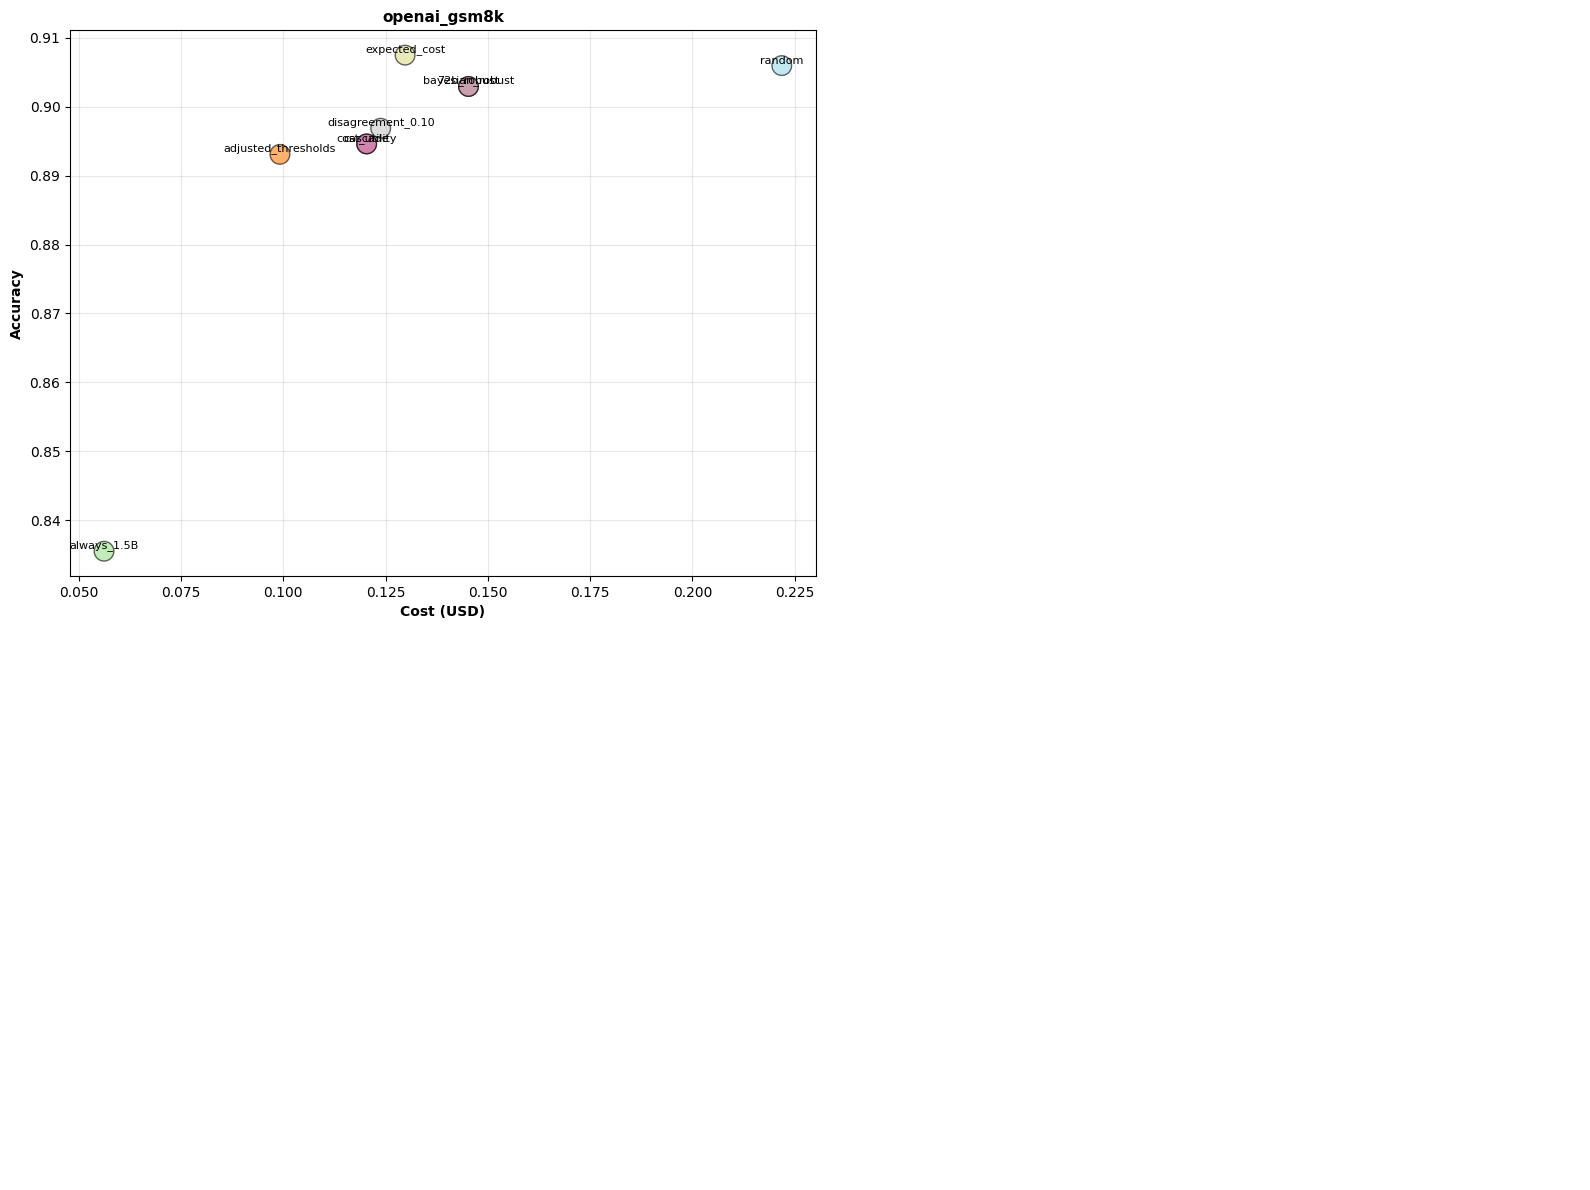


DATASET-SPECIFIC STRATEGY PERFORMANCE

OPENAI_GSM8K:
Strategy                            Accuracy     Cost         Efficiency  
-----------------------------------------------------------------------
expected_cost                       0.9075       $0.1298     6.993945
random                              0.9060       $0.2218     4.084060
72b_robust                          0.9030       $0.1453     6.216339
bayesian_robust                     0.9030       $0.1453     6.216450
disagreement_0.10                   0.8969       $0.1238     7.244992
cascade                             0.8946       $0.1203     7.434296
cost_utility                        0.8946       $0.1204     7.431307
adjusted_thresholds                 0.8931       $0.0992     9.006419
always_1.5B                         0.8355       $0.0562     14.875376


In [81]:
# === DATASET-SPECIFIC STRATEGY COMPARISON ===

if not strategy_results_df.empty:
    datasets = sorted(strategy_results_df['dataset'].unique())
    n_datasets = len(datasets)
    
    # Create subplots for each dataset
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, dataset in enumerate(datasets):
        if idx >= 4:  # Max 4 subplots
            break
        
        ax = axes[idx]
        dataset_data = strategy_results_df[strategy_results_df['dataset'] == dataset]
        
        # Scatter plot: cost vs accuracy for this dataset
        strategies = dataset_data['strategy'].values
        costs = dataset_data['cost'].values
        accuracies = dataset_data['accuracy'].values
        
        scatter = ax.scatter(costs, accuracies, s=200, alpha=0.6, c=range(len(strategies)), 
                           cmap='tab20', edgecolor='black', linewidth=1)
        
        # Annotate points with strategy names
        for i, strategy in enumerate(strategies):
            ax.annotate(strategy, (costs[i], accuracies[i]), 
                       fontsize=8, ha='center', va='bottom')
        
        ax.set_xlabel('Cost (USD)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
        ax.set_title(f'{dataset}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(datasets), 4):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed dataset comparisons
    print("\n" + "=" * 80)
    print("DATASET-SPECIFIC STRATEGY PERFORMANCE")
    print("=" * 80)
    
    for dataset in datasets:
        dataset_data = strategy_results_df[strategy_results_df['dataset'] == dataset].copy()
        dataset_data = dataset_data.sort_values('accuracy', ascending=False)
        
        print(f"\n{dataset.upper()}:")
        print(f"{'Strategy':<35} {'Accuracy':<12} {'Cost':<12} {'Efficiency':<12}")
        print("-" * 71)
        
        for _, row in dataset_data.iterrows():
            eff = row['accuracy'] / (row['cost'] + 1e-6)
            print(f"{row['strategy']:<35} {row['accuracy']:.4f}       ${row['cost']:<10.4f} {eff:.6f}")


In [82]:
# === ROUTING DECISION BREAKDOWN ===
# Analyze how each router allocates questions to different models

print("\n" + "="*80)
print("ROUTING ALLOCATION ANALYSIS")
print("="*80)

routing_allocations = []

for dataset in strategy_results_df['dataset'].unique():
    try:
        # Load cascade results for this dataset
        cascade_path = f"../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/{dataset}_routed/answered_cascade.parquet"
        cascade_df = pd.read_parquet(cascade_path)
        
        route_counts = cascade_df['route_to'].value_counts()
        total = len(cascade_df)
        
        print(f"\n{dataset.upper()} - CASCADE ROUTER:")
        print(f"{'Model':<50} {'Count':<8} {'Percentage':<12}")
        print("-" * 70)
        
        for model, count in route_counts.items():
            pct = 100 * count / total
            # Get cost ratio
            if "1.5B" in model:
                cost_ratio = 1.0
            elif "7B" in model:
                cost_ratio = 2.0
            else:
                cost_ratio = 9.0
            print(f"{model:<50} {count:<8} {pct:>6.1f}% (cost: {cost_ratio:.1f}x)")
        
        avg_cost = sum((route_counts.get(model, 0) / total) * 
                      (1.0 if "1.5B" in model else (2.0 if "7B" in model else 9.0))
                      for model in route_counts.index)
        print(f"\nAverage Cost Multiplier: {avg_cost:.2f}x")
        
    except Exception as e:
        print(f"Could not load routing data for {dataset}: {e}")

print("\n" + "="*80)



ROUTING ALLOCATION ANALYSIS

OPENAI_GSM8K - CASCADE ROUTER:
Model                                              Count    Percentage  
----------------------------------------------------------------------
Qwen/Qwen2.5-Math-1.5B-Instruct                    1012       76.7% (cost: 1.0x)
Qwen/Qwen2.5-Math-7B-Instruct                      167        12.7% (cost: 2.0x)
Qwen/Qwen2.5-Math-72B-Instruct                     140        10.6% (cost: 9.0x)

Average Cost Multiplier: 1.98x



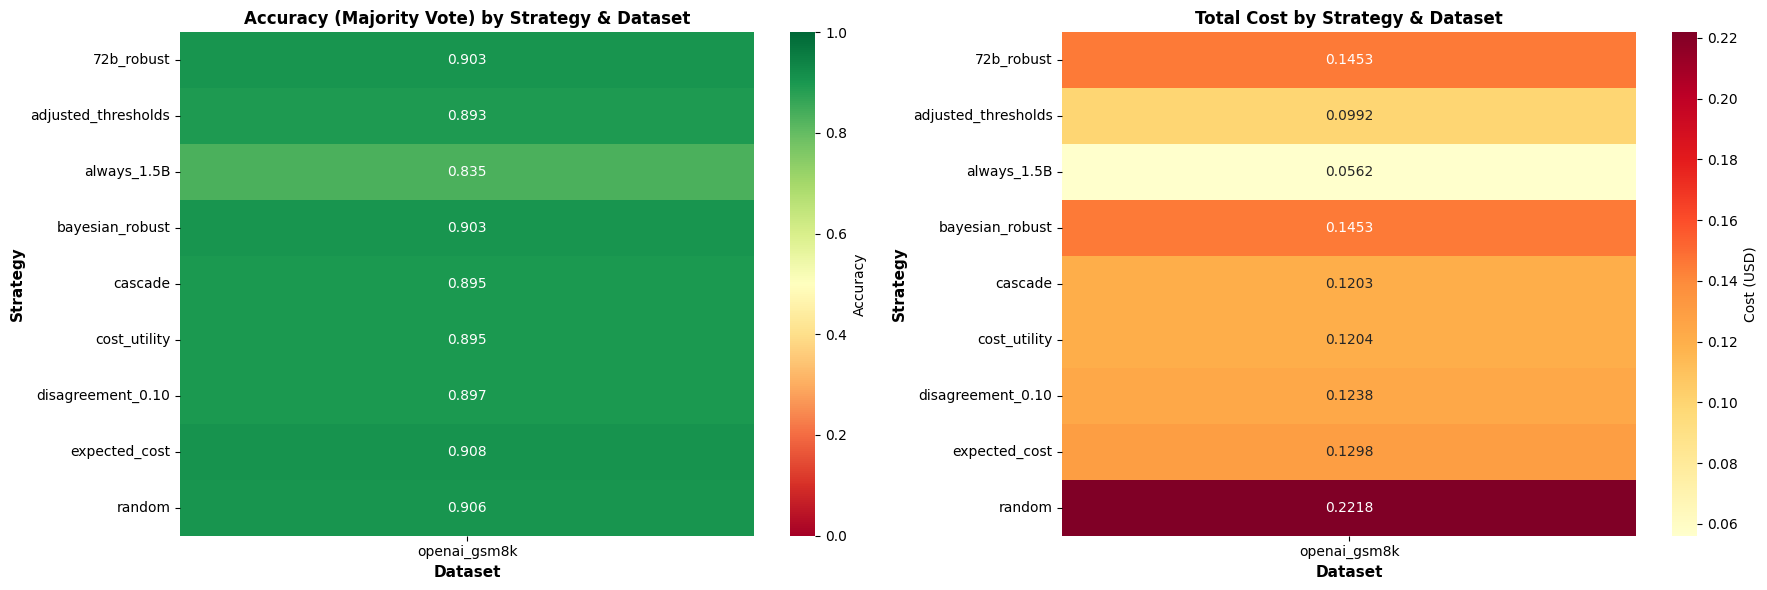


HEATMAP INSIGHTS

Best Accuracy:
  Strategy: expected_cost
  Dataset: openai_gsm8k
  Accuracy: 0.9075

Lowest Cost:
  Strategy: always_1.5B
  Dataset: openai_gsm8k
  Cost: $0.0562

Highest Efficiency (Accuracy/Cost):
  Strategy: always_1.5B
  Dataset: openai_gsm8k
  Efficiency: 14.875376



In [83]:
# === DETAILED ROUTER COMPARISON MATRIX ===
# Create heatmaps showing performance across datasets

import seaborn as sns

if not strategy_results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Prepare pivot tables - use 'strategy' instead of 'router'
    accuracy_pivot = strategy_results_df.pivot_table(values='accuracy', index='strategy', columns='dataset')
    cost_pivot = strategy_results_df.pivot_table(values='cost', index='strategy', columns='dataset')
    
    # Calculate efficiency for heatmap
    strategy_results_df['efficiency'] = strategy_results_df['accuracy'] / (strategy_results_df['cost'] + 1e-6)
    efficiency_pivot = strategy_results_df.pivot_table(values='efficiency', index='strategy', columns='dataset')
    
    # 1. Accuracy Heatmap
    sns.heatmap(accuracy_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0], 
                cbar_kws={'label': 'Accuracy'}, vmin=0, vmax=1)
    axes[0].set_title('Accuracy (Majority Vote) by Strategy & Dataset', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Strategy', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Dataset', fontsize=11, fontweight='bold')
    
    # 2. Cost Heatmap
    sns.heatmap(cost_pivot, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[1],
                cbar_kws={'label': 'Cost (USD)'})
    axes[1].set_title('Total Cost by Strategy & Dataset', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Strategy', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Dataset', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("HEATMAP INSIGHTS")
    print("="*80)
    
    # Find best performers
    print("\nBest Accuracy:")
    best_acc = strategy_results_df.loc[strategy_results_df['accuracy'].idxmax()]
    print(f"  Strategy: {best_acc['strategy']}")
    print(f"  Dataset: {best_acc['dataset']}")
    print(f"  Accuracy: {best_acc['accuracy']:.4f}")
    
    print("\nLowest Cost:")
    lowest_cost = strategy_results_df.loc[strategy_results_df['cost'].idxmin()]
    print(f"  Strategy: {lowest_cost['strategy']}")
    print(f"  Dataset: {lowest_cost['dataset']}")
    print(f"  Cost: ${lowest_cost['cost']:.4f}")
    
    print("\nHighest Efficiency (Accuracy/Cost):")
    best_efficiency = strategy_results_df.loc[strategy_results_df['efficiency'].idxmax()]
    print(f"  Strategy: {best_efficiency['strategy']}")
    print(f"  Dataset: {best_efficiency['dataset']}")
    print(f"  Efficiency: {best_efficiency['efficiency']:.6f}")
    
    print("\n" + "="*80)
else:
    print("⚠ No strategy results loaded. Run cell 9 (LOAD ALL ROUTING STRATEGY RESULTS) first.")

In [84]:
# === STRATEGY RANKING & STATISTICAL ANALYSIS ===

from scipy import stats

if not strategy_results_df.empty:
    print("\n" + "="*80)
    print("STRATEGY STATISTICAL COMPARISON")
    print("="*80)
    
    # Group comparisons by metric
    metrics = ['accuracy', 'passk', 'cost', 'efficiency']
    
    for metric in metrics:
        print(f"\n{metric.upper()} RANKING:")
        print("-" * 80)
        
        if metric == 'cost':
            # For cost, lower is better
            ranking = strategy_results_df.groupby('strategy')[metric].mean().sort_values()
        else:
            # For others, higher is better
            ranking = strategy_results_df.groupby('strategy')[metric].mean().sort_values(ascending=False)
        
        for i, (strategy, value) in enumerate(ranking.items(), 1):
            if metric == 'cost':
                print(f"{i}. {strategy:<50} ${value:.4f}")
            elif metric == 'efficiency':
                print(f"{i}. {strategy:<50} {value:.6f} (acc/cost)")
            else:
                print(f"{i}. {strategy:<50} {value:.4f}")
    
    # Compare average strategy performance
    print("\n" + "-"*80)
    print("SUMMARY STATISTICS")
    print("-"*80)
    print(f"Total strategies evaluated: {strategy_results_df['strategy'].nunique()}")
    print(f"Total datasets: {strategy_results_df['dataset'].nunique()}")
    print(f"Total result points: {len(strategy_results_df)}")
    print(f"\nStrategies:")
    for strategy in sorted(strategy_results_df['strategy'].unique()):
        count = len(strategy_results_df[strategy_results_df['strategy'] == strategy])
        avg_acc = strategy_results_df[strategy_results_df['strategy'] == strategy]['accuracy'].mean()
        avg_cost = strategy_results_df[strategy_results_df['strategy'] == strategy]['cost'].mean()
        print(f"  - {strategy:<35} {count} datasets | Avg Acc: {avg_acc:.4f} | Avg Cost: ${avg_cost:.4f}")
    
    print("\n" + "="*80)
else:
    print("⚠ No strategy results loaded. Run cell 9 (LOAD ALL ROUTING STRATEGY RESULTS) first.")


STRATEGY STATISTICAL COMPARISON

ACCURACY RANKING:
--------------------------------------------------------------------------------
1. expected_cost                                      0.9075
2. random                                             0.9060
3. 72b_robust                                         0.9030
4. bayesian_robust                                    0.9030
5. disagreement_0.10                                  0.8969
6. cascade                                            0.8946
7. cost_utility                                       0.8946
8. adjusted_thresholds                                0.8931
9. always_1.5B                                        0.8355

PASSK RANKING:
--------------------------------------------------------------------------------
1. expected_cost                                      0.9075
2. random                                             0.9060
3. 72b_robust                                         0.9030
4. bayesian_robust                    